
# Módulo 2: Extracción de sentimientos y opiniones

## Scripts de los métodos explicados en el módulo

A continuación, se presentan los scripts que ejemplifican los métodos explicados en PLA-2.

Paquetes requeridos para ejecutar este notebook, además de los comentados en el notebook anterior (Notebook-PLA1):
- rdflib y neuralcoref (previa instalación de spaCy). Para la instalación podéis usar "pip" o "conda", según el sistema que tengáis instalado.

- Recordad que tenéisq que mantener la misma estructura de las carpetas para que el código encuentre los ficheros .csv y las imágenes que se usan. 

<u>Nota</u>: Se recomienda emplear la versión 3.6 de Python.

## 1. Detección de los componentes de una opinión ##

### 1.1 Detección de las distintas denominaciones del <i>target</i> ###

Mostramos cómo se detecta el <i>target</i> en sus distintas variaciones:
<ol>
<li>Hiperónimo</li>
<li>Sinónimo</li>
<li>Referencia anafórica</li>
</ol>

#### Comprobar si el término A es un hiperónimo del término B consultando DBpedia ####

In [1]:
#Importamos la librería para poder hacer las consultas en la DBpedia
#La respuesta de DBpedia es un grafo y la información se estructura en formato RDF
import rdflib
from rdflib import Graph, URIRef, RDF

#Método para saber si A es un hiperónimo de B
def is_hyperonym(source,target):
    dbpedia_uri = URIRef('http://dbpedia.org/resource/'+ source) #Uri que apunta a A en DBpedia
    g = Graph()
    g.parse(dbpedia_uri)#Se parsea la respuesta de DBpedia en forma de grafo
    url_matches = []
    for obj in g.objects(subject=dbpedia_uri, predicate=RDF.type): #Buscamos en el grafo información
        #sobre los objetos del predicado 'type' cuando el sujeto es la uri que apunta a A
        #Se recogen las referencias al objeto de 'type' según Yago en las que esté B
        if 'http://dbpedia.org/class/yago/' in obj and target in obj:
            url_matches.append(obj)
    #Si hay referencias al objeto de type que contienen B, entonces A es su hiperónimo
    if len(url_matches) > 0:
        print(target, "ES UN HIPERÓNIMO DE", source)
    else:
        print(target, "NO ES UN HIPERÓNIMO DE ", source)

is_hyperonym('IPhone','Telephone')


Telephone ES UN HIPERÓNIMO DE IPhone


#### Comprobar si A es un sinónimo de B con <i>word embeddings</i>. ####

In [2]:
import gensim
import nltk
from nltk.corpus import wordnet as wn

#Cargamos el modelo Word2Vec de opiniones sobre smartphones
model = gensim.models.Word2Vec.load('MODEL-MOBILEPHONE-REVIEWS-PL2')

term = 'samsung'

#Obtenemos los phrases más similares al término a partir del modelo Word2Vec
most_similars = model.wv.most_similar(positive=term)

print("PHRASES CON VALOR DE SIMILITUD", most_similars)

#De la lista de phrases más similares (score de similitud > 0.4) tomamos los sintagmas nominales 
#(NN, NS o JJ+NN, NN+NN, NN+NS)

def is_np(candidate):
    test = False
    tokens = candidate.split()
    tagged_tokens = nltk.pos_tag(tokens)
    #Si es un término multipalabra
    if len(tagged_tokens) > 1:
        PoS_initial = tagged_tokens[0][1][:2]
        PoS_final = tagged_tokens[-1][1][:2]
        if ((PoS_initial == 'NN' or PoS_initial == 'JJ') and (PoS_final == 'NN' or PoS_final == 'NS')):
            test = True
    #Si es un término monopalabra
    else:
        if len(candidate) > 1 and tagged_tokens[0][1][:2] == 'NN' or tagged_tokens[0][1][:2] == 'NS':
            test = True 
    return test


target_candidates = [tc[0] for tc in most_similars if tc[1] > 0.4 and is_np(tc[0]) == True]

print("CANDIDATOS A TARGET", target_candidates)


PHRASES CON VALOR DE SIMILITUD [('samsung products', 0.5297491550445557), ('htc', 0.5151442885398865), ('lg', 0.5053367018699646), ('galaxy', 0.4459127187728882), ('touch wiz', 0.4367666244506836), ('touchwiz', 0.43020638823509216), ('samsungs', 0.40303096175193787), ('quite frankly', 0.39835870265960693), ('called samsung', 0.3946046233177185), ('marketing', 0.3945105969905853)]
CANDIDATOS A TARGET ['samsung products', 'htc', 'lg', 'galaxy', 'touch wiz', 'touchwiz', 'samsungs']


#### Referencia anafórica al <i>target</i> ####

In [ ]:
# !pip install spacy==2.1.0
# !pip install neuralcoref
# !python3 -m spacy download en_core_web_sm

In [1]:

import neuralcoref
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm')
coref = neuralcoref.NeuralCoref(nlp.vocab)

nlp.add_pipe(coref, name='neuralcoref')

doc = nlp(u'I bought an iPhone a few days ago. It was such a nice phone. \
The touch screen was really cool. The voice quality was clear too. \
However, my mother was mad with me as I did not tell her before I bought it. \
Although the battery life was not long, that is ok for me')

print(doc._.has_coref)
print(doc._.coref_clusters)
print(doc._.coref_resolved)

100%|██████████| 40155833/40155833 [00:18<00:00, 2135059.22B/s]


True
[an iPhone: [an iPhone, It], The touch screen: [The touch screen, it], my mother: [my mother, her], me: [me, me]]
I bought an iPhone a few days ago. an iPhone was such a nice phone. The touch screen was really cool. The voice quality was clear too. However, my mother was mad with me as I did not tell my mother before I bought The touch screen. Although the battery life was not long, that is ok for me


### 1.2 Detección de los aspectos ###

#### Obtener las propiedades de un producto según una <i>infobox</i> de la Wikipedia ####

In [2]:
import requests

#Obtener las propiedades del target 'IPhone', consultando el grafo de DBpedia 
#y obteniendo la información en formato RDF

def get_properties(target):
    data = requests.get("http://dbpedia.org/data/" + target + ".json").json()
    uris = data["http://dbpedia.org/resource/" + target]
    properties = []

    for u in uris:
        if '/property/' in u:
            us = u.split('/')
            properties.append(us[-1])       
    return properties

target = 'IPhone'

properties_target = get_properties(target)

print(properties_target)


['wikiPageUsesTemplate', 'logo', 'name', 'caption', 'unitssold', 'type', 'storage', 'power', 'service', 'sound', 'related', 'manufacturer', 'os', 'developer']


#### Detección de los aspectos por <i>clustering</i> de sus synsets de Wordnet ###

In [3]:
#De una opinión, tomamos los candidatos a ser aspectos del target

import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.collocations import *
import re
import collections

#Un candidato a ser aspecto es un término monopalabra o multipalabra que forma un sintagma nominal (is_np)

def is_np(candidate):
    test = False
    tokens = candidate.split()
    tagged_tokens = nltk.pos_tag(tokens)
    if len(tagged_tokens) > 1:
        PoS_initial = tagged_tokens[0][1][:2]
        PoS_final = tagged_tokens[-1][1][:2]
        if ((PoS_initial == 'NN' or PoS_initial == 'JJ') and (PoS_final == 'NN' or PoS_final == 'NS')):
            test = True
    else:
        if len(candidate) > 1 and tagged_tokens[0][1][:2] == 'NN' or tagged_tokens[0][1][:2] == 'NS':
            test = True 
    return test

def get_np_candidates(text):
    #Definimos las métricas que evaluaran si un n-grama puede ser una collocation
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    #Tokenizamos y obtenemos los tokens del texto
    tokens = [w for w in word_tokenize(text.lower())]
    #Búsqueda de bigramas
    bigramfinder = BigramCollocationFinder.from_words(tokens)
    #Se toman los bigramas que no tienen signos de puntuación, etc.
    bigramfinder.apply_word_filter(lambda w: (re.match(r'\W', w)))
    #N mejores candidatos a ser colocaciones, tras pasar por el cálculo del PMI
    bigram_candidates = bigramfinder.nbest(bigram_measures.pmi,100)
    #Transformación de la tupla del bigrama a collocation
    collocation_candidates = [" ".join(bc) for bc in bigram_candidates]
    #Elegimos los candidatos que son sintagmas nominales
    np_candidates = [c for c in tokens + collocation_candidates if is_np(c) == True]
    return np_candidates

opinion = "I bought an iPhone a few days ago. It was such a nice phone. The touch screen was really cool. \
The voice quality was clear too. Although the battery life was not long, that is ok for me. However, \
my mother was mad with me as I did not tell her before I bought it. She also thought the phone was too expensive, \
and wanted me to return it to the shop"

np_candidates = get_np_candidates(opinion)


In [4]:
#Transformamos los candidatos a aspecto a sus synsets de Wordnet, cuando estos synsets son nominales

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

lem = WordNetLemmatizer()

np_candidates.append('telephone') # Ponemos el hiperónimo de ìPhone

candidates_synsets_list = []

for npc in np_candidates:
    candidates_synsets = wn.synsets(lem.lemmatize(npc.replace(' ','_')),pos=wn.NOUN)
    for cs in candidates_synsets:
        if "'" + npc.replace(' ','_') + ".n" in str(cs):
            candidates_synsets_list.append(cs)


In [5]:
#Transformamos las propiedades del target, según Wikipedia, a sus synsets de Wordnet, cuando son nominales

import requests

#Obtener las propiedades del target 'IPhone', según Wikipedia

def get_properties(target):
    data = requests.get("http://dbpedia.org/data/" + target + ".json").json()
    uris = data["http://dbpedia.org/resource/" + target]
    properties = []

    for u in uris:
        if '/property/' in u:
            us = u.split('/')
            properties.append(us[-1])       
    return properties

target = 'IPhone'

properties_target = get_properties(target)

features_synsets_list = []

for pt in properties_target:
    features_synsets = wn.synsets(lem.lemmatize(pt.replace(' ','_')),pos=wn.NOUN)
    for fs in features_synsets:
        if "'" + pt + ".n" in str(fs):
            features_synsets_list.append(fs)


In [6]:
#Creamos los vectores que representan a los candidatos a aspecto
#Los vectores se construyen calculando la distancia de cada synset del candidato a aspecto con cada synset de 
#la propiedad del target

from numpy import matrix

def create_vector(synset, synsets_vocabulary):
    vector = [s.wup_similarity(synset) for s in synsets_vocabulary] #Wu and Palmer score
    return vector

vectors = [create_vector(v,features_synsets_list) for v in candidates_synsets_list]

X = matrix(vectors)

print(X)


[[0.28571429 0.83333333 0.26666667 ... 0.15384615 0.16666667 0.13333333]
 [0.26666667 0.30769231 0.25       ... 0.14285714 0.15384615 0.125     ]
 [0.22222222 0.25       0.21052632 ... 0.11764706 0.125      0.10526316]
 ...
 [0.1        0.11111111 0.0952381  ... 0.36363636 0.38095238 0.57142857]
 [0.11764706 0.13333333 0.11111111 ... 0.42105263 0.44444444 0.77777778]
 [0.11764706 0.13333333 0.11111111 ... 0.42105263 0.44444444 0.66666667]]


In [10]:
from sklearn.cluster import KMeans
import numpy as np

#Clustering de los vectores

num_clusters = 5

km = KMeans(n_clusters=num_clusters, n_init=10) # n_init para mantener la consistencia

X = np.asarray(X)

km.fit(X)

labels = km.labels_.tolist()

labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404'
}

class_0 = []
class_1 = []
class_2 = []
class_3 = []
class_4 = []

for i in range(len(labels)):
    if labels[i] == 0:
        class_0.append(candidates_synsets_list[i])
    if labels[i] == 1:
        class_1.append(candidates_synsets_list[i])
    if labels[i] == 2:
        class_2.append(candidates_synsets_list[i])
    if labels[i] == 3:
        class_3.append(candidates_synsets_list[i])
    if labels[i] == 4:
        class_4.append(candidates_synsets_list[i])

print("CLASS_0", class_0)
print("CLASS_1", class_1)
print("CLASS_2", class_2)
print("CLASS_3", class_3)
print("CLASS_4", class_4)


CLASS_0 [Synset('phone.n.02'), Synset('touch.n.03'), Synset('touch.n.06'), Synset('voice.n.02'), Synset('voice.n.06'), Synset('voice.n.10'), Synset('battery.n.01'), Synset('battery.n.03'), Synset('battery.n.04'), Synset('life.n.05'), Synset('life.n.06'), Synset('life.n.07'), Synset('phone.n.02'), Synset('return.n.06')]
CLASS_1 [Synset('screen.n.01'), Synset('screen.n.03'), Synset('screen.n.04'), Synset('screen.n.05'), Synset('screen.n.09'), Synset('voice.n.07'), Synset('battery.n.02'), Synset('battery.n.05'), Synset('life.n.08'), Synset('life.n.10'), Synset('life.n.11'), Synset('mother.n.01'), Synset('mother.n.02'), Synset('mother.n.03'), Synset('mother.n.04'), Synset('tell.n.01'), Synset('shop.n.01'), Synset('touch_screen.n.01'), Synset('telephone.n.01'), Synset('telephone.n.02')]
CLASS_2 [Synset('touch.n.01'), Synset('touch.n.05'), Synset('touch.n.08'), Synset('touch.n.09'), Synset('voice.n.03'), Synset('voice.n.05'), Synset('battery.n.07'), Synset('life.n.13'), Synset('return.n.02')

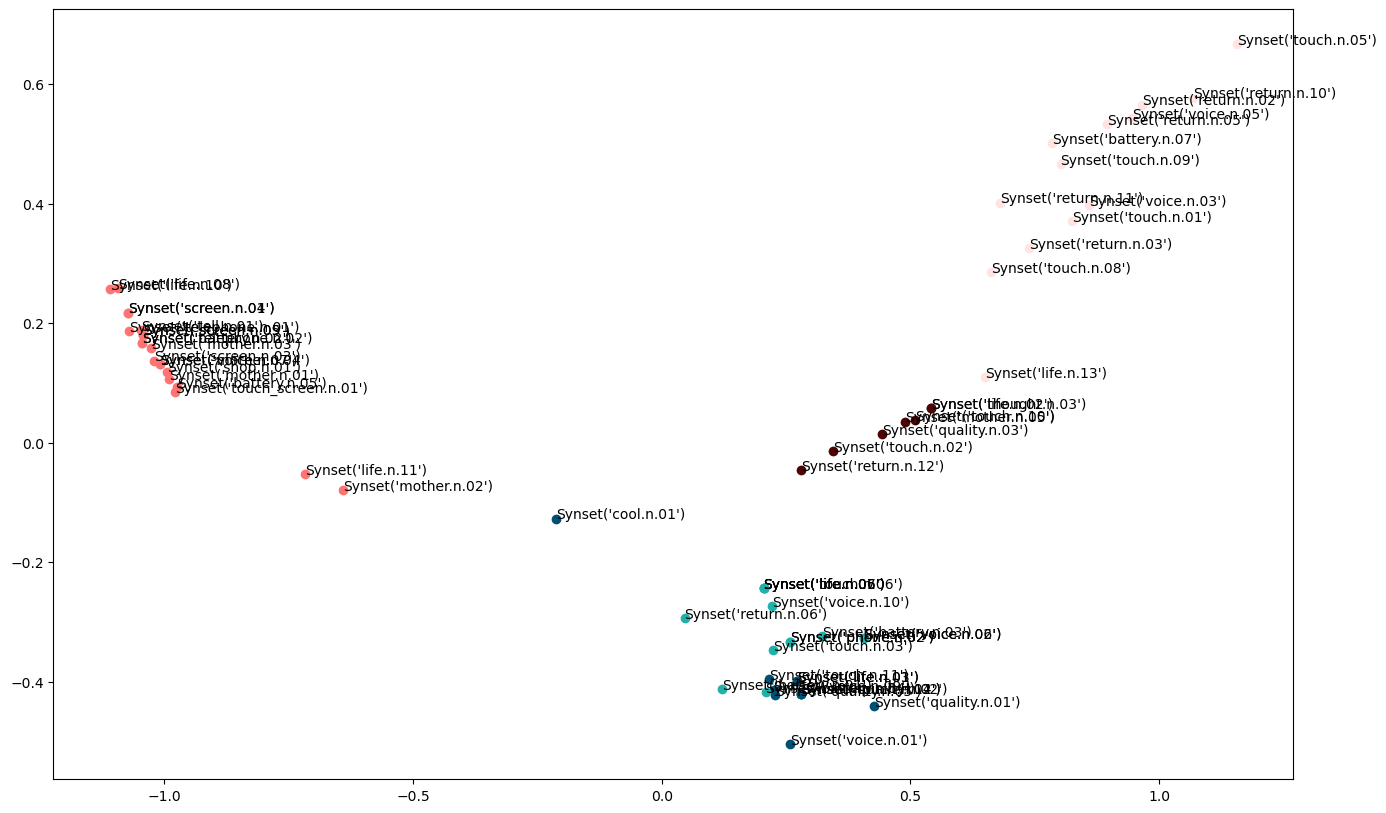

In [12]:
#Visualización

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(X)

fig, ax = plt.subplots(figsize=(16,10))
for index, instance in enumerate(reduced_data):
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
    ax.annotate(text=str(candidates_synsets_list[index]), xy=(pca_comp_1, pca_comp_2))
plt.show()



#### Detección de los aspectos a partir de <i>opinion words</i> ###

In [13]:
#Obtenemos los candidatos a ser aspectos y la lista de opinion words

import gensim
from nltk.stem.wordnet import WordNetLemmatizer

lem = WordNetLemmatizer()

#Los candidatos a aspecto ya han sido obtenidos antes (np_candidates). 
#Solo falta lematizarlos

print(np_candidates)

#Creamos una lista de opinion words a partir del diccionario AFINN
opinion_words_file = 'AFINN-111.txt'

opinion_words = []

with open(opinion_words_file, 'r') as of:
    ol = of.readlines()
    for wo in ol:
        w, o = wo.strip().split('\t')
        opinion_words.append(w)

#Obtenemos los lemas unificados de los candidatos a aspecto si no están en la lista de opinion words

def unify(l):
    term_unified = l
    if l == 'touch_screen':
        term_unified = 'touchscreen'
    return term_unified

aspect_candidates = [unify(lem.lemmatize(ac.replace(' ','_'))) for ac in np_candidates if ac not in opinion_words]

print(aspect_candidates)


['bought', 'iphone', 'days', 'phone', 'touch', 'screen', 'cool', 'voice', 'quality', 'battery', 'life', 'ok', 'mother', 'mad', 'tell', 'bought', 'thought', 'phone', 'return', 'shop', 'battery life', 'few days', 'touch screen', 'voice quality', 'nice phone', 'telephone']
['bought', 'iphone', 'day', 'phone', 'touch', 'screen', 'voice', 'quality', 'battery', 'life', 'ok', 'mother', 'tell', 'bought', 'thought', 'phone', 'return', 'shop', 'battery_life', 'few_days', 'touchscreen', 'voice_quality', 'nice_phone', 'telephone']


In [15]:
# Cargamos el modelo de opiniones sobre smartphones
model = gensim.models.Word2Vec.load('MODEL-MOBILEPHONE-REVIEWS-PL2')

# Creamos el vocabulario, que es la lista de candidatos a término y las opinion words que están en la opinión
# y en el modelo
opinion_words_in_opinion = [ow for ow in word_tokenize(opinion.lower()) if ow in opinion_words]

vocabulary = aspect_candidates + opinion_words_in_opinion

# Actualizado para Gensim 4.0.0+
vocabulary_in_model = [v.replace('_',' ') for v in vocabulary if v.replace('_',' ') in model.wv.key_to_index]

# Creamos los vectores de los elementos del vocabulario...
import numpy as np

def sem_distance(a, o):
    cosine_similarity = np.dot(model.wv[a], model.wv[o]) / (np.linalg.norm(model.wv[a]) * np.linalg.norm(model.wv[o]))
    return cosine_similarity

def create_vector(v, vocabulary):
    vector = [sem_distance(v, vb) for vb in vocabulary]
    return vector

# Asegúrate de que `vocabulary_in_model` solo contiene palabras que están en `model.wv`
vocabulary_in_model = [v for v in vocabulary_in_model if v in model.wv]

vectors = [create_vector(v, vocabulary_in_model) for v in vocabulary_in_model if v in model.wv]



In [17]:
#Clustering

from numpy import matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = matrix(vectors)

X = np.asarray(X)

num_clusters = 3

km = KMeans(n_clusters=num_clusters, n_init=5) # initial number in order to keep consistency

km.fit(X)

labels = km.labels_.tolist()

class_0 = []
class_1 = []
class_2 = []

for i in range(len(labels)):
    if labels[i] == 0:
        class_0.append(vocabulary_in_model[i])
    if labels[i] == 1:
        class_1.append(vocabulary_in_model[i])
    if labels[i] == 2:
        class_2.append(vocabulary_in_model[i])

print("CLASS_0", class_0)
print("CLASS_1", class_1)
print("CLASS_2", class_2)


CLASS_0 ['day', 'phone', 'battery', 'life', 'phone', 'battery life']
CLASS_1 ['bought', 'mother', 'tell', 'bought', 'thought', 'return', 'shop', 'telephone', 'mad']
CLASS_2 ['iphone', 'touch', 'screen', 'voice', 'quality', 'ok', 'touchscreen', 'voice quality', 'nice', 'cool', 'clear']


### 1.3 Detección de la polaridad ###

#### Preprocesado ####

In [18]:
#Preprocesado de twits

import re

##Quitar emojis

text = "Adicto a la lectura. Apasionado de la política y la economía. Balonmano, naturaleza y mucha música.😎.\
        Dibujo tebeos como croquetas, feministo 😈 y... a veces soy Clara te canta 🎤"

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
print(text)
print(emoji_pattern.sub(r'', text)) # no emoji

## Quitar urls

text = "AEP es un proyecto para difundir material anarquista existente. https://t.co/Nxv9arm4Ti en consulta"

no_http_text = re.sub(r'(\s)http\S+', '', text) #\S+ matches any non-whitespace character

print (text)
print(no_http_text)

## Quitar hashtags

text = "Tinc 4 #PremisTuitort per ser cuqui i fer #Rubiadas, dos @GatsMalvats"

print(text)

no_hash_arr_text = text = re.sub(r'[#@]', '', text)

print (no_hash_arr_text)


Adicto a la lectura. Apasionado de la política y la economía. Balonmano, naturaleza y mucha música.😎.        Dibujo tebeos como croquetas, feministo 😈 y... a veces soy Clara te canta 🎤
Adicto a la lectura. Apasionado de la política y la economía. Balonmano, naturaleza y mucha música..        Dibujo tebeos como croquetas, feministo  y... a veces soy Clara te canta 
AEP es un proyecto para difundir material anarquista existente. https://t.co/Nxv9arm4Ti en consulta
AEP es un proyecto para difundir material anarquista existente. en consulta
Tinc 4 #PremisTuitort per ser cuqui i fer #Rubiadas, dos @GatsMalvats
Tinc 4 PremisTuitort per ser cuqui i fer Rubiadas, dos GatsMalvats


#### Clasificación de la polaridad de un twit ####

In [19]:
import nltk
from nltk import word_tokenize

#Corpus de entrenamiento

#Tweets que se consideran de polaridad positiva

pos_tweets = ['I love this car.', 'This view is amazing.', 'I feel great this morning.', 
              'I am so excited about the concert.', 'He is my best friend.']

#Tweets que se consideran de polaridad negativa

neg_tweets = ['I do not like this car.', 'This view is horrible.', 'I feel tired this morning.',
              'I am not looking forward to the concert.', 'He is my enemy.']

#Creamos los documentos de entrenamiento: uno para cada tipo opinión

docs = pos_tweets + neg_tweets

print("TRAINING TWEETS",docs)

#Definimos el vectorizador
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(
    analyzer= 'word',
 )

#Entrenamiento

data_labels = []

for i in range(len(pos_tweets)):
    data_labels.append('POS')                #Data labelling

for i in range(len(neg_tweets)):
    data_labels.append('NEG')

print("TRAINING DATA LABELS", data_labels)

X = vectorizer.fit_transform(docs)

X_train = X.toarray()  #Matriz con los vectores de entrenamiento

from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()  #Definición del clasificador bayesiano

bayes_model = classifier.fit(X=X_train, y=data_labels)  #Entrenamiento del clasificador aplicando 
                                                        #el método al corpus de entrenamiento

#Predicción

new_tweets = ['Larry is my friend', 'The film is horrible']

X1 = vectorizer.transform(new_tweets)

y_pred = bayes_model.predict(X1)

for i in range(len(new_tweets)):
    print ("LA POLARIDAD DE", new_tweets[i], "ES", y_pred[i])


TRAINING TWEETS ['I love this car.', 'This view is amazing.', 'I feel great this morning.', 'I am so excited about the concert.', 'He is my best friend.', 'I do not like this car.', 'This view is horrible.', 'I feel tired this morning.', 'I am not looking forward to the concert.', 'He is my enemy.']
TRAINING DATA LABELS ['POS', 'POS', 'POS', 'POS', 'POS', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG']
LA POLARIDAD DE Larry is my friend ES POS
LA POLARIDAD DE The film is horrible ES NEG


### 1.4 <i>Opinion holder</i> ###

<b>Obtener el perfil de una cuenta</b>

In [20]:
import tweepy
from tweepy import API
from tweepy import OAuthHandler

CONSUMER_KEY = XXXXX
CONSUMER_SECRET = XXXXX
ACCESS_KEY = XXXXX
ACCESS_SECRET = XXXXX

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)

api = tweepy.API(auth)

description_user = api.get_user('@realDonaldTrump').description

print (description_user)


ModuleNotFoundError: No module named 'tweepy'

### 1.5 Tiempo ###

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Time
2016-03-31      10
2016-04-01      28
2016-04-02      19
2016-04-03     359
2016-04-04    1450
2016-04-05     145
2016-04-06      77
2016-04-07      20
2016-04-08      66
Name: Time, dtype: int64


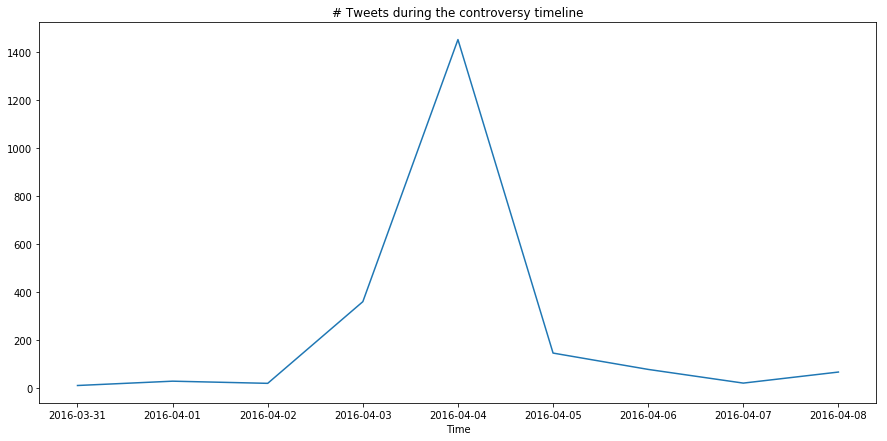

In [ ]:
#Timeline de los twits publicados sobre la controversia generada por el programa La Gent Normal.

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

df =pd.read_csv("lagentnormal-CORPUS.csv", sep='\t', encoding='utf-8')

df1 = df[['Time','User']]

df1['Time'] = pd.to_datetime(df1['Time']).dt.date #Quitar horas y minutos

df1 = df1.groupby('Time').Time.count()
print (df1)

fig, ax = plt.subplots(figsize=(15,7))
df1.plot(title='# Tweets during the controversy timeline')
plt.show()
